In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools, viz_tools
import xarray as xr
from IPython.core.display import display, HTML
import scipy.signal as signal
import glob
import matplotlib.cm as cm
from matplotlib import animation, rc
import cmocean
import datetime
import matplotlib.gridspec as gridspec
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
rc('animation', html='html5')

In [3]:
grid = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
mesh_mask = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
winds_data = xr.open_dataset(
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

In [5]:
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)

In [13]:
def make_video(sal_full, trc_full):
    fig, ax = plt.subplots(figsize = (18,9))
    gs = gridspec.GridSpec(4, 2)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1:4, 0])
    ax3 = plt.subplot(gs[1:4, 1])
    for ax in [ax2, ax3]:
        ax.tick_params(labelleft = False, left = False, bottom = False, labelbottom = False)
    plt.tight_layout()
    viz_tools.set_aspect(ax2)
    viz_tools.set_aspect(ax3)
    first = nc.num2date(sal_full.variables['time_counter'][0], 
                        sal_full.variables['time_counter'].units)
    end_index = sal_full.variables['time_counter'][:].shape[0]
    times = np.array([first + datetime.timedelta(hours = i) for i in range(end_index)])
    averaged_SI_u_winds = np.array([])
    averaged_SI_v_winds = np.array([])
    averaged_SS_u_winds = np.array([])
    averaged_SS_v_winds = np.array([])
    for n in range(end_index):
        SI_u_winds = winds_data.u_wind.isel(gridY=slice(159,162), 
                                            gridX=slice(119,122)).sel(time=times[n], 
                                                                      method = 'nearest').values
        averaged_SI_u_winds = np.append(averaged_SI_u_winds, np.mean(SI_u_winds))
        SI_v_winds = winds_data.v_wind.isel(gridY=slice(159,162), 
                                            gridX=slice(119,122)).sel(time=times[n], 
                                                                      method = 'nearest').values
        averaged_SI_v_winds = np.append(averaged_SI_v_winds, np.mean(SI_v_winds))
        SS_u_winds = winds_data.u_wind.isel(gridY=slice(182,185), 
                                            gridX=slice(106,109)).sel(time=times[n], 
                                                                      method = 'nearest').values
        averaged_SS_u_winds = np.append(averaged_SS_u_winds, np.mean(SS_u_winds))
        SS_v_winds = winds_data.v_wind.isel(gridY=slice(182,185), 
                                            gridX=slice(106,109)).sel(time=times[n], 
                                                                      method = 'nearest').values
        averaged_SS_v_winds = np.append(averaged_SS_v_winds, np.mean(SS_v_winds))
    rotated_SI_u_winds, rotated_SI_v_winds = viz_tools.rotate_vel(averaged_SI_u_winds, 
                                                                  averaged_SI_v_winds, 
                                                                  origin = 'map' )
    rotated_SS_u_winds, rotated_SS_v_winds = viz_tools.rotate_vel(averaged_SS_u_winds, 
                                                                  averaged_SS_v_winds, 
                                                                  origin = 'map' )
    SIwindfu = signal.filtfilt(B,A, rotated_SI_u_winds)
    SIwindfv = signal.filtfilt(B,A, rotated_SI_v_winds)
    SSwindfu = signal.filtfilt(B,A, rotated_SS_u_winds)
    SSwindfv = signal.filtfilt(B,A, rotated_SS_v_winds)
    ax1.set_title('Averaged and Filtered Winds')
    depths = sal_full.variables['deptht'][:]
    def init():
        s = ax2.pcolormesh(np.ma.masked_array(sal_full.variables['vosaline'][0, 2, 550:800, 115:250],
                                     mask = 1 - mesh_mask.variables['tmask'][0,2,550:800, 115:250]),
                  vmin = 22, vmax = 30, cmap = cmocean.cm.haline
                  )
        fig.colorbar(s, ax=ax2)
        t = ax2.pcolormesh(np.ma.masked_array(trc_full.variables['mytracer'][0, 2, 550:800, 115:250],
                                     mask = 1 - mesh_mask.variables['tmask'][0,2,550:800, 115:250]),
                  vmin = 0, vmax = 1, cmap = 'Purples'
                  )
        fig.colorbar(t, ax=ax3)
        return ax
    def animate30(i):
        date = times[i]
        for ax in [ax1, ax2, ax3]:
            ax.clear()
        cmap = plt.get_cmap('Purples')
        cmap.set_bad('burlywood')
        ax1.plot(times, SIwindfu, '--', color = 'teal')
        ax1.plot(times, SIwindfv, '-', color = 'teal')
        ax1.plot(times, SSwindfu, '--', color = 'tomato')
        ax1.plot(times, SSwindfv, '-', color = 'tomato')
        ax1.grid('on')
        ax1.set_ylim(-10,15)
        ax1.plot((date, date), (-10,15), 'b--', color = 'black')
        ax2.pcolormesh(np.ma.masked_array(sal_full.variables['vosaline'][i,0,550:800, 115:250], 
                                          mask = 1 - mesh_mask.variables['tmask'][0, 0, 550:800, 115:250]),
                       cmap = cmocean.cm.haline, vmin = 22, vmax = 30)
        ax3.pcolormesh(np.ma.masked_array(trc_full.variables['mytracer'][i,0,550:800, 115:250], 
                                          mask = 1 - mesh_mask.variables['tmask'][0, 0, 550:800, 115:250]),
                       cmap = cmap, vmin = 0, vmax = 1)
        ax2.set_title('Salinity - Full')
        ax3.set_title('Tracer - Full')
        return ax
    interval = 0.25#in seconds
    ani40 = animation.FuncAnimation(fig,animate30,frames=end_index,init_func = init, 
                                    interval=interval*1e+3, repeat=False)
    return ani40

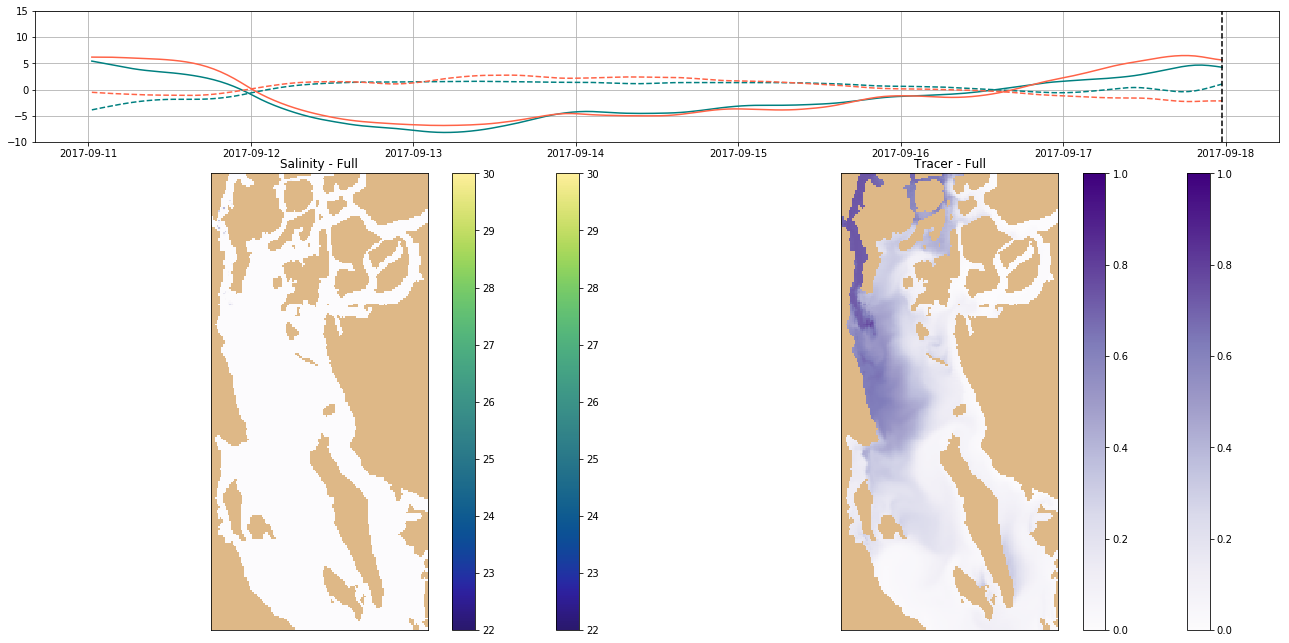

In [14]:
make_video(nc.Dataset(
'/ocean/vdo/MEOPAR/completed-runs/SalishSea_TRC/round2/sep17/SalishSea_1h_20170911_20170917_grid_T.nc'),
          nc.Dataset(
'/ocean/vdo/MEOPAR/completed-runs/SalishSea_TRC/round2/sep17/SalishSea_1h_20170911_20170917_ptrc_T.nc'))

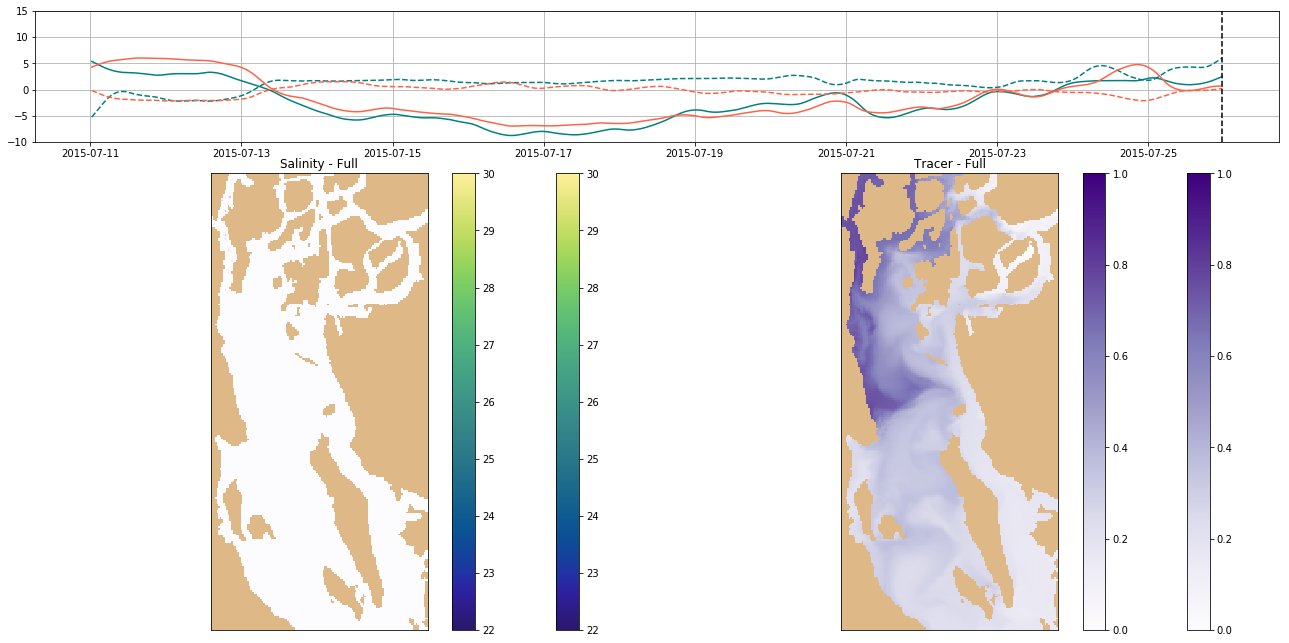

In [15]:
make_video(nc.Dataset(
'/ocean/vdo/MEOPAR/completed-runs/SalishSea_TRC/round2/jul15/SalishSea_1h_20150711_20150725_grid_T.nc'),
          nc.Dataset(
'/ocean/vdo/MEOPAR/completed-runs/SalishSea_TRC/round2/jul15/SalishSea_1h_20150711_20150725_ptrc_T.nc'))